# File and libraries

In [3]:
import pandas as pd
import numpy as np

filepath=r'dataset/df_ecom_2_6_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

sample_filepath=f"{filepath}_sample.csv"
test_sample_filepath=f"{filepath}_test_sample.csv"
train_sample_filepath=f"{filepath}_train_sample.csv"

file_tag = "Multicategory Store"

# DSLabs functions

In [4]:
%run "dslabs_functions.py"


dslabs_functions lodaded


# Data functions

In [5]:
%run "data_functions.py"


dslabs_functions lodaded
data_functions loaded


# Load

In [6]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False


if test_data==True:

    df=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    sample=0.1
    df = df.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    test = test.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train = train.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)


    
    
else:
    # data=pd.read_csv(f"{filepath}.csv")  
    # test= pd.read_csv(test_filepath)
    # train= pd.read_csv(train_filepath)

    # use 10% sample file when heavy processing
    df=pd.read_csv(sample_filepath)
    test= pd.read_csv(test_sample_filepath)
    train= pd.read_csv(train_sample_filepath)
 
 
target='is_purchase'
eval_metric_1='precision'
eval_metric_2='f2'
vars: list[str] = df.columns.to_list()
labels: list = list(df[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
df.sort_values(by='day', inplace=True)
test.sort_values(by='day', inplace=True)
train.sort_values(by='day', inplace=True)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21185 entries, 0 to 21184
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   category_code_lvl_1  21185 non-null  float64
 1   category_code_lvl_2  21185 non-null  float64
 2   price                21185 non-null  float64
 3   is_purchase          21185 non-null  int64  
 4   activity_in_session  21185 non-null  float64
 5   week_of_month        21185 non-null  int64  
 6   day                  21185 non-null  int64  
 7   brand_value          21185 non-null  float64
 8   product_category     21185 non-null  int64  
 9   day_of_week_sin      21185 non-null  float64
 10  day_of_week_cos      21185 non-null  float64
 11  hour_sin             21185 non-null  float64
 12  hour_cos             21185 non-null  float64
dtypes: float64(9), int64(4)
memory usage: 2.3 MB


# Distribution Check

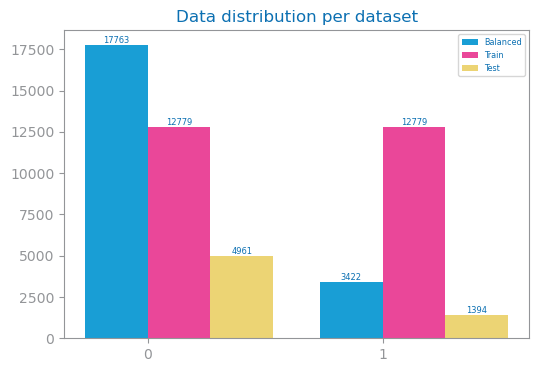

In [7]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Balanced": [
        len(df[df[target] == 0]),  # Assuming 0 is the negative class
        len(df[df[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

# eval prep

In [10]:
trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

Train#=25558 Test#=6355
Labels=[0, 1]


In [11]:

def mlp_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_iterations: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
    file_tag='',
) -> tuple[MLPClassifier | None, dict]:
    nr_iterations: list[int] = [lag] + [
        i for i in range(2 * lag, nr_max_iterations + 1, lag)
    ]

    lr_types: list[Literal["constant", "invscaling", "adaptive"]] = [
        "constant",
        "invscaling",
        "adaptive",
    ]  # only used if optimizer='sgd'
    learning_rates: list[float] = [0.5, 0.05, 0.005, 0.0005]

    best_model: MLPClassifier | None = None
    best_params: dict = {"name": "MLP", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    _, axs = subplots(
        1, len(lr_types), figsize=(len(lr_types) * HEIGHT, HEIGHT), squeeze=False
    )
    for i in range(len(lr_types)):
        type: str = lr_types[i]
        values = {}
        for lr in learning_rates:
            warm_start: bool = False
            y_tst_values: list[float] = []
            for j in range(len(nr_iterations)):
                clf = MLPClassifier(
                    learning_rate=type,
                    learning_rate_init=lr,
                    max_iter=lag,
                    warm_start=warm_start,
                    activation="logistic",
                    solver="sgd",
                    verbose=False,
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                warm_start = True
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (type, lr, nr_iterations[j])
                    best_model = clf
                print(f'MLP lr_type={type} lr={lr} n={nr_iterations[j]}')
            values[lr] = y_tst_values
        plot_multiline_chart(
            nr_iterations,
            values,
            ax=axs[0, i],
            title=f"{file_tag} - MLP with {type}",
            xlabel="nr iterations",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'MLP best for {best_params["params"][2]} iterations (lr_type={best_params["params"][0]} and lr={best_params["params"][1]}'
    )

    return best_model, best_params



# f2

In [13]:
max_iter_eval=1000
lag_eval=100

## f2 study

MLP lr_type=constant lr=0.5 n=100
MLP lr_type=constant lr=0.5 n=200
MLP lr_type=constant lr=0.5 n=300
MLP lr_type=constant lr=0.5 n=400
MLP lr_type=constant lr=0.5 n=500
MLP lr_type=constant lr=0.5 n=600
MLP lr_type=constant lr=0.5 n=700
MLP lr_type=constant lr=0.5 n=800
MLP lr_type=constant lr=0.5 n=900
MLP lr_type=constant lr=0.5 n=1000
MLP lr_type=constant lr=0.05 n=100
MLP lr_type=constant lr=0.05 n=200
MLP lr_type=constant lr=0.05 n=300
MLP lr_type=constant lr=0.05 n=400
MLP lr_type=constant lr=0.05 n=500
MLP lr_type=constant lr=0.05 n=600
MLP lr_type=constant lr=0.05 n=700
MLP lr_type=constant lr=0.05 n=800
MLP lr_type=constant lr=0.05 n=900
MLP lr_type=constant lr=0.05 n=1000
MLP lr_type=constant lr=0.005 n=100
MLP lr_type=constant lr=0.005 n=200
MLP lr_type=constant lr=0.005 n=300
MLP lr_type=constant lr=0.005 n=400
MLP lr_type=constant lr=0.005 n=500
MLP lr_type=constant lr=0.005 n=600
MLP lr_type=constant lr=0.005 n=700
MLP lr_type=constant lr=0.005 n=800
MLP lr_type=constant

<Figure size 640x480 with 0 Axes>

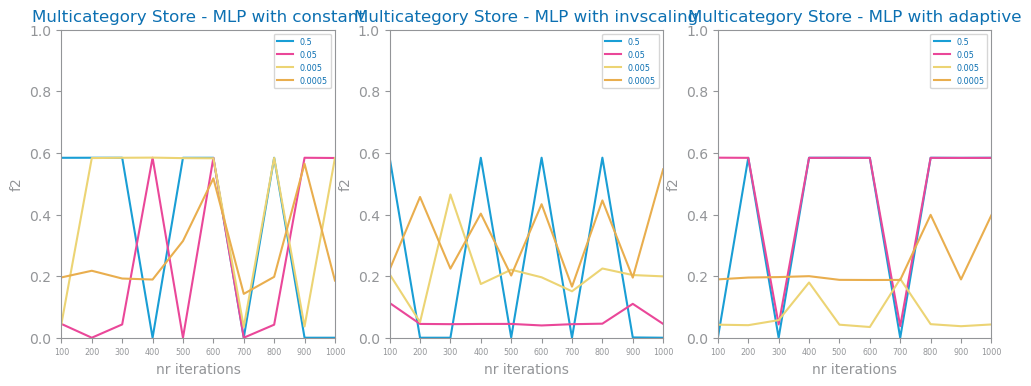

In [14]:
figure()

best_model_f2, f2_params = mlp_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_iterations=max_iter_eval,
    lag=lag_eval,
    metric='f2',
    file_tag=file_tag
)
savefig(f"images/{file_tag}_mlp_{f2_params['metric']}_study.png")
show()

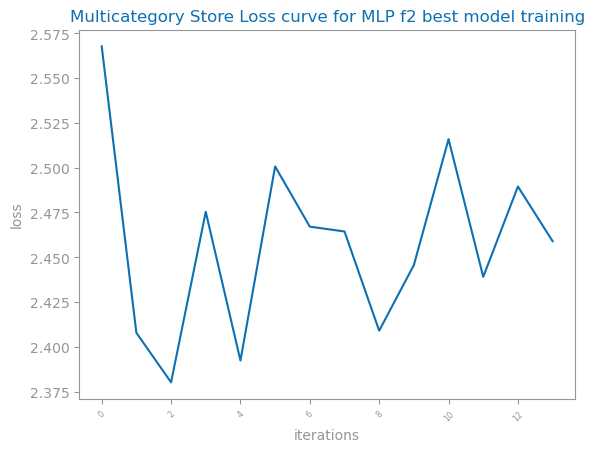

In [15]:
figure()
plot_line_chart(
    arange(len(best_model_f2.loss_curve_)),
    best_model_f2.loss_curve_,
    title=f"{file_tag} Loss curve for MLP {f2_params['metric']} best model training",
    xlabel="iterations",
    ylabel="loss",
    percentage=False,
)
savefig(f"images/{file_tag}_mlp_{f2_params['metric']}_loss_curve.png")

## f2 best model

<Figure size 640x480 with 0 Axes>

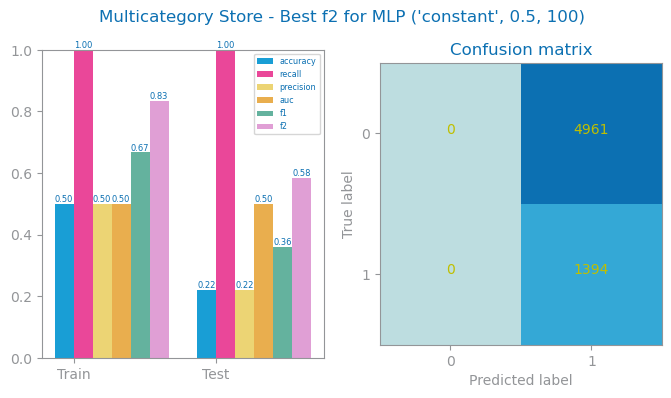

In [33]:
prd_trn: array = best_model_f2.predict(trnX)
prd_tst: array = best_model_f2.predict(tstX)
figure()
plot_evaluation_results(f2_params, trnY, prd_trn, tstY, prd_tst, labels,file_tag=file_tag)
savefig(f'images/{file_tag}_mlp_{f2_params["name"]}_best_{f2_params["metric"]}_eval.png')
show()

## f2 Overfitting

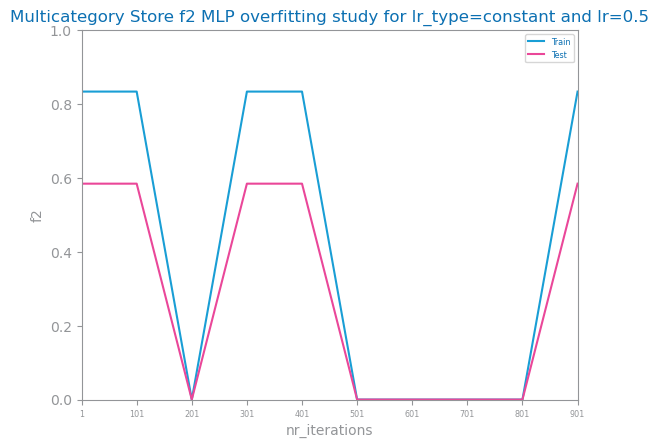

In [34]:
lr_type: Literal["constant", "invscaling", "adaptive"] = f2_params["params"][0]
lr: float = f2_params["params"][1]
nr_iterations: list[int] = [i for i in range(1, max_iter_eval, lag_eval)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric = f2_params['metric']

warm_start: bool = False
for n in nr_iterations:
    clf = MLPClassifier(
        warm_start=warm_start,
        learning_rate=lr_type,
        learning_rate_init=lr,
        max_iter=n,
        activation="logistic",
        solver="sgd",
        verbose=False,
    )
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))
    warm_start = True

figure()
plot_multiline_chart(
    nr_iterations,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} {eval_metric} MLP overfitting study for lr_type={lr_type} and lr={lr}",
    xlabel="nr_iterations",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_mlp_{eval_metric}_overfitting.png")

# precision

## precision study

In [27]:
max_iter_eval=80
lag_eval=5

MLP lr_type=constant lr=0.5 n=5
MLP lr_type=constant lr=0.5 n=10
MLP lr_type=constant lr=0.5 n=15
MLP lr_type=constant lr=0.5 n=20
MLP lr_type=constant lr=0.5 n=25
MLP lr_type=constant lr=0.5 n=30
MLP lr_type=constant lr=0.5 n=35
MLP lr_type=constant lr=0.5 n=40
MLP lr_type=constant lr=0.5 n=45
MLP lr_type=constant lr=0.5 n=50
MLP lr_type=constant lr=0.5 n=55
MLP lr_type=constant lr=0.5 n=60
MLP lr_type=constant lr=0.5 n=65
MLP lr_type=constant lr=0.5 n=70
MLP lr_type=constant lr=0.5 n=75
MLP lr_type=constant lr=0.5 n=80
MLP lr_type=constant lr=0.05 n=5
MLP lr_type=constant lr=0.05 n=10
MLP lr_type=constant lr=0.05 n=15
MLP lr_type=constant lr=0.05 n=20
MLP lr_type=constant lr=0.05 n=25
MLP lr_type=constant lr=0.05 n=30
MLP lr_type=constant lr=0.05 n=35
MLP lr_type=constant lr=0.05 n=40
MLP lr_type=constant lr=0.05 n=45
MLP lr_type=constant lr=0.05 n=50
MLP lr_type=constant lr=0.05 n=55
MLP lr_type=constant lr=0.05 n=60
MLP lr_type=constant lr=0.05 n=65
MLP lr_type=constant lr=0.05 n=7

<Figure size 640x480 with 0 Axes>

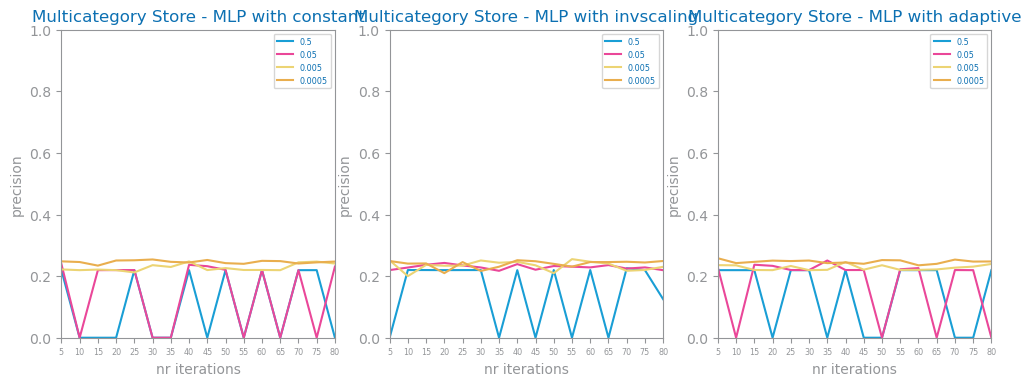

In [28]:

figure()

best_model_prec, prec_params = mlp_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_iterations=max_iter_eval,
    lag=lag_eval,
    metric='precision',
    file_tag=file_tag
)
savefig(f"images/{file_tag}_mlp_{prec_params['metric']}_study.png")
show()

## precision best model

max=500
lag = 50

<Figure size 640x480 with 0 Axes>

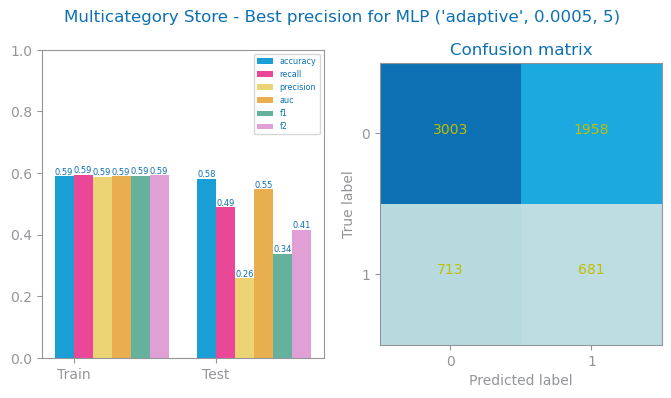

In [29]:
prd_trn: array = best_model_prec.predict(trnX)
prd_tst: array = best_model_prec.predict(tstX)
figure()
plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag)
savefig(f'images/{file_tag}_mlp_{prec_params["name"]}_best_{prec_params["metric"]}_eval.png')
show()

max=200
lag = 20

## precision overfitting

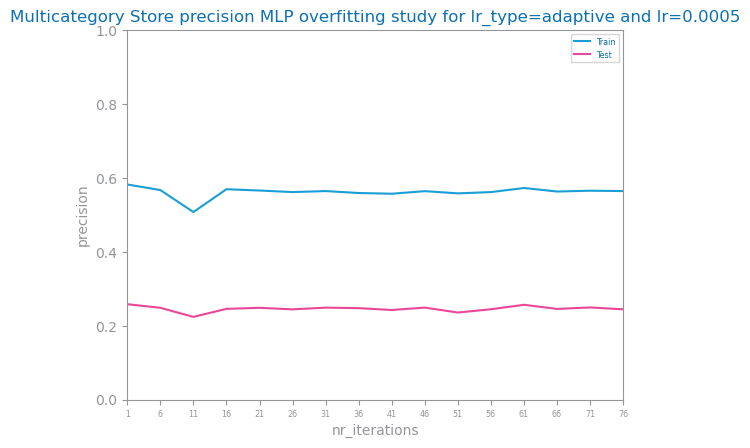

In [30]:
lr_type: Literal["constant", "invscaling", "adaptive"] = prec_params["params"][0]
lr: float = prec_params["params"][1]
nr_iterations: list[int] = [i for i in range(1, max_iter_eval, lag_eval)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric = prec_params['metric']

warm_start: bool = False
for n in nr_iterations:
    clf = MLPClassifier(
        warm_start=warm_start,
        learning_rate=lr_type,
        learning_rate_init=lr,
        max_iter=n,
        activation="logistic",
        solver="sgd",
        verbose=False,
    )
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))
    warm_start = True

figure()
plot_multiline_chart(
    nr_iterations,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} {eval_metric} MLP overfitting study for lr_type={lr_type} and lr={lr}",
    xlabel="nr_iterations",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_mlp_{eval_metric}_overfitting.png")

# Analysis

Precision/recall/ f2 study:
- recall KNN best with K=5
- Precision KNN best with  K=5
- f2 KNN best with K=3

Logic for evaluation:
- Our goal is to maximize true positives (high recall) while minimizing false positives (high precision). This approach enables us to effectively identify customers who are likely to purchase, focusing our marketing efforts on those most likely to convert. By reducing false positives, we also avoid unnecessary spending on campaigns targeted at users who are unlikely to buy.

- The F2 score, which places more emphasis on recall than precision, is the best metric to evaluate this balance. During the evaluation phase, we will assess model performance primarily using the F2 score, analyzing precision and recall together. Our objective is to achieve a balanced score that allows us to identify as many potential buyers as possible, while keeping false positives low to optimize our marketing budget.

Dataset used:
- Sample from balancing dataset was used, as running the evaluation on the with complete balancing dataset was too time-consuming.

Precision/Recall/F2 Analysis:

To optimize for F2, we tested several iterations to find the best balance between precision and recall. We found that precision and recall scores barely changed regardless of the number of iterations. The optimized F2 model, with parameters (constant, 0.5, 100), achieved 100% recall, indicating it identified all true positives in the test set. However, with only 22% precision and accuracy, the model is essentially classifying all samples as positive, resulting in only true positives and false positives. This clearly suggests that the F2-optimized model is not suitable for our dataset in MLP.
For the best precision model, suitable metrics for our dataset were obtained with parameters (constant, 0.0005, 50). This setup yielded ~52% recall, correctly predicting more than half of true positives, and 26% precision, thus achieving a favorable balance between true positives and minimizing false positives.
Compared to the best F2 model, the precision-optimized model is much more appropriate for our dataset and should be used for class prediction.
Overfitting:

For both the best F2 and precision models, there is no overfitting. Whenever the F2/precision score varies in the training set, a similar variation occurs in the test set.

Comparing with other algorithms:
- 

## Extended analysis

- To optimize for F2, we tested several iterations to find the best balance between precision and recall. We found that precision and recall scores barely changed regardless of the number of iterations. The optimized F2 model, with parameters (constant, 0.5, 100), achieved 100% recall, indicating it identified all true positives in the test set. However, with only 22% precision and accuracy, the model is essentially classifying all samples as positive, resulting in only true positives and false positives. This clearly suggests that the F2-optimized model is not suitable for our dataset in MLP.
- For the best precision model, suitable metrics for our dataset were obtained with parameters (constant, 0.0005, 50). This setup yielded ~52% recall, correctly predicting more than half of true positives, and 26% precision, thus achieving a favorable balance between true positives and minimizing false positives.
- Compared to the best F2 model, the precision-optimized model is much more appropriate for our dataset and should be used for class prediction.
- For both the best F2 and precision models, there is no overfitting. Whenever the F2/precision score varies in the training set, a similar variation occurs in the test set.

- Comparing the performance with other models:this setup was limited.

## Short analysis for the report
- Testing showed that F2 optimization produced a high-recall but low-precision model, unsuitable for our dataset. Precision-optimized model (constant, 0.0005, 50) performed better and is recommended. No overfitting.

# Short logic evaluation text:
- Our goal is to maximize true positives (high recall) and minimize false positives (high precision), effectively targeting likely buyers and reducing wasted marketing spend. The F2 score, emphasizing recall, will be our primary evaluation metric, helping us strike a balance between precision and recall to optimize campaign efficiency